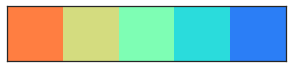

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain
import os

from statannot import add_stat_annotation

sns.set(style = 'white', font='Arial',  font_scale=2)

color = sns.color_palette("rainbow_r",5) #PiYG
sns.palplot(color)

In [2]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import roc_auc_score, matthews_corrcoef, precision_score, recall_score, f1_score


def score(dfr):
    y_true = dfr.y_true
    y_score = dfr.y_score
    y_pred = dfr.y_score.round()

    '''
    the metrics are taken from orignal paper:
    Meta-Signer: Metagenomic Signature Identifier based on Rank Aggregation of Features
    https://github.com/YDaiLab/Meta-Signer/blob/bd6a1cd98d1035f848ecb6e53d9ee67a85871db2/src/utils/metasigner_io.py#L34
    '''
    auc = roc_auc_score(y_true, y_score, average='weighted')        
    mcc = matthews_corrcoef(y_true, y_pred)
    pres = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    #print('roc-auc: %.3f, mcc: %.3f, pres: %.3f, recall: %.3f, f1: %.3f' % (auc, mcc, pres, recall, f1))

    return auc, mcc, pres, recall, f1

In [3]:
paths = ['./mapping_Cirrhosis_results',
        './mapping_T2D_results', 
         './mapping_Obesity_results', 
         './mapping_IBD_results']

names = ['Cirrhosis', 'T2D', 'Obesity', 'IBD']

alldf = []
for ps, name in zip(paths, names):
    df = pd.read_pickle(os.path.join(ps, 'dfres_10FCV_10times.pkl'))
    df['dataset'] = name
    alldf.append(df)
dfres = pd.concat(alldf).reset_index(drop=True)

res = dfres.apply(score, axis=1)
ms = res.apply(pd.Series)
ms.columns = ['auc', 'mcc', 'pres', 'recall', 'f1']
dfres = dfres[['method',  'dataset', 'repeat_seed', 'fold']].join(ms)

/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` p

In [4]:
def plot_sig(dfp, x, y, order, ax, ylim):

    color = sns.color_palette("rainbow_r", len(order)) #PiYG

    box = []
    for i in range(len(order)):
        if i == 0:
            continue
        box.append((order[0], order[i]))

    
    sns.boxplot(data=dfp, x=x, y=y, order=order,  ax = ax, palette=color, fliersize=0, )
    sns.stripplot(data=dfp, x=x, y=y, order=order, ax = ax, jitter=True, 
                  size=5, palette=color, split=True,
                  linewidth=0.5,edgecolor='gray')

    res = add_stat_annotation(ax, data = dfp, x=x, y=y, order=order, plot='boxplot',
                        box_pairs=box,
                        test='t-test_paired',  comparisons_correction = None,
                        text_format='star', use_fixed_offset = True, line_offset_to_box = 0, line_offset = 0.01, 
                        loc='outside', verbose=0)

    ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)

    if ylim == None:
        pass
    else:
        
        ymax = ax.get_ylim()[1]
        ymin = ylim[0]
        ax.set_ylim((ymin, ymax))
    
    ax.set_xlabel(data)
    ax.set_ylabel('')

    ax.set_xticklabels(order, rotation=45, ha = 'right')
                  
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


    return ax

/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


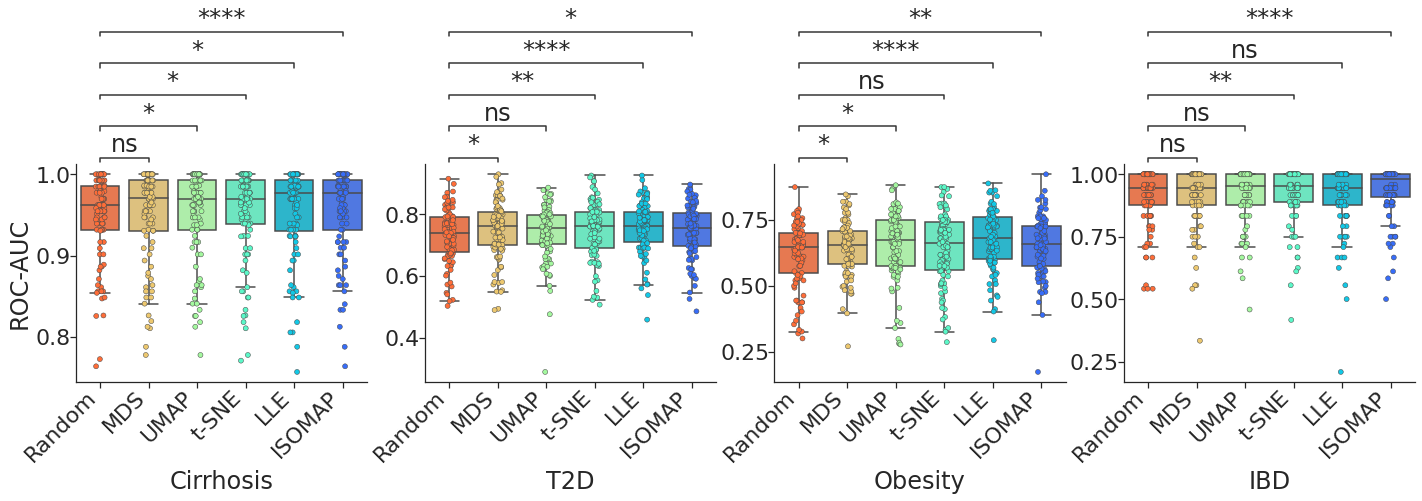

In [12]:
order = ['Random', 'MDS', 'UMAP',  't-SNE', 'LLE', 'ISOMAP'] 
color = sns.color_palette("rainbow_r", len(order)).as_hex() #PiYG

ylims = [(0.8, 1.01), (0.4, 1.0), (0.25, 0.90), (0.5, 1.05)]

fig, axes = plt.subplots(1, 4, figsize = (24, 4), sharex=True)

for metric in ['auc']: #, 'mcc', 'f1'
    for data,ax,ylim in zip(names, axes, ylims):
        x = "method"
        y = metric
        #data = 'Cirrhosis'
        dfp = dfres[dfres.dataset == data]
        ax = plot_sig(dfp, x, y, order, ax, ylim=None)
        plt.xticks(rotation=45, ha = 'right')
        
axes[0].set_ylabel('ROC-AUC')

fig.savefig("./results/00_ROC_stat.pdf" ,  bbox_inches='tight')

/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


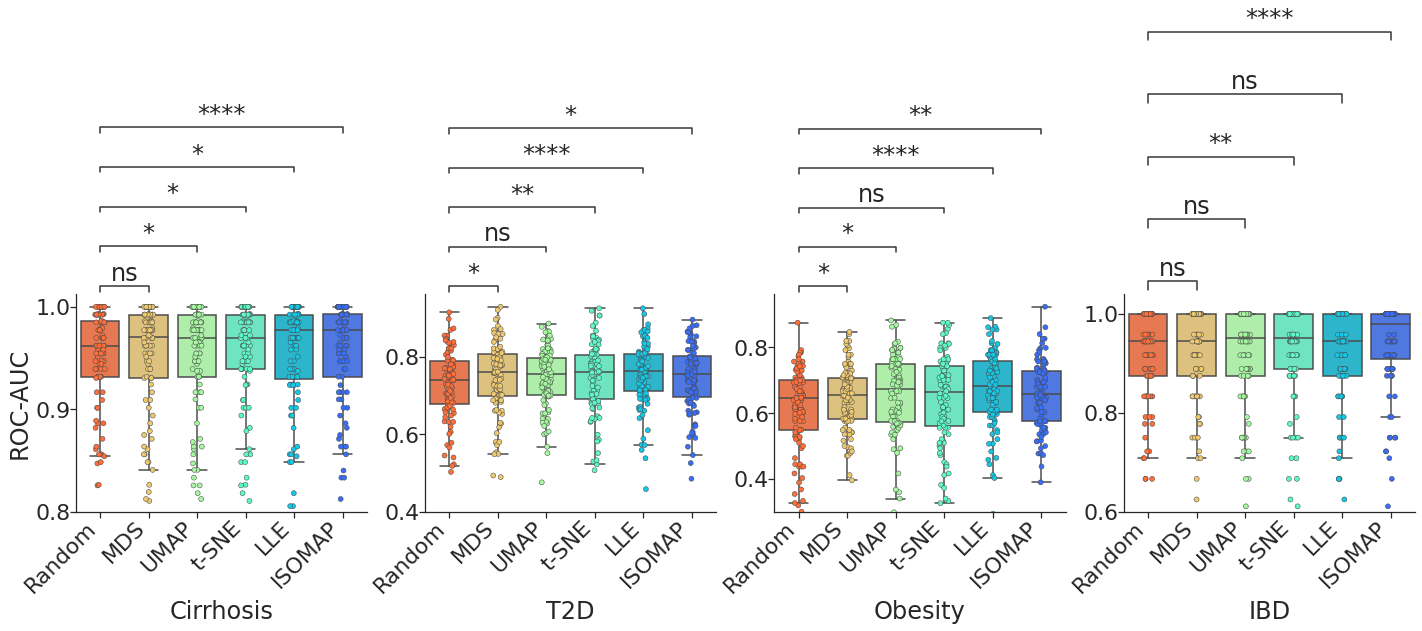

In [11]:
order = ['Random', 'MDS', 'UMAP',  't-SNE', 'LLE', 'ISOMAP'] 
color = sns.color_palette("rainbow_r", len(order)).as_hex() #PiYG

ylims = [(0.8, 1.01), (0.4, 1.0), (0.30, 0.90), (0.6, 1.05)]

fig, axes = plt.subplots(1, 4, figsize = (24, 4), sharex=True)

for metric in ['auc']: #, 'mcc', 'f1'
    for data,ax,ylim in zip(names, axes, ylims):
        x = "method"
        y = metric
        #data = 'Cirrhosis'
        dfp = dfres[dfres.dataset == data]
        ax = plot_sig(dfp, x, y, order, ax, ylim=ylim)
        plt.xticks(rotation=45, ha = 'right')
        
axes[0].set_ylabel('ROC-AUC')

fig.savefig("./results/01_ROC_stat.pdf" ,  bbox_inches='tight')


/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


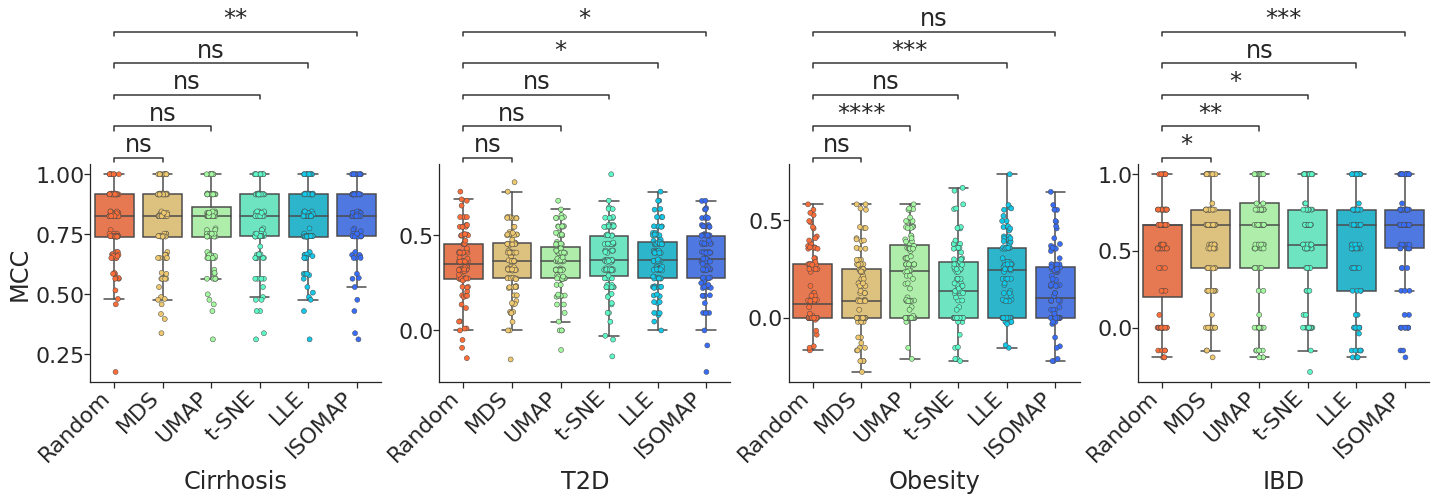

In [10]:
order = ['Random', 'MDS', 'UMAP',  't-SNE', 'LLE', 'ISOMAP'] 
color = sns.color_palette("rainbow_r", len(order)).as_hex() #PiYG

fig, axes = plt.subplots(1, 4, figsize = (24, 4), sharex=True)

for metric in ['mcc']: #, 'mcc', 'f1'
    for data,ax,ylim in zip(names, axes, ylims):
        x = "method"
        y = metric
        #data = 'Cirrhosis'
        dfp = dfres[dfres.dataset == data]
        ax = plot_sig(dfp, x, y, order, ax, ylim=None)
        plt.xticks(rotation=45, ha = 'right')
        
axes[0].set_ylabel('MCC')

fig.savefig("./results/02_MCC_stat.pdf" ,  bbox_inches='tight')


/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
/home/shenwanxiang/anaconda3/envs/aggmap/lib/python3.7/site-packages/seaborn/categorical.py:2792: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


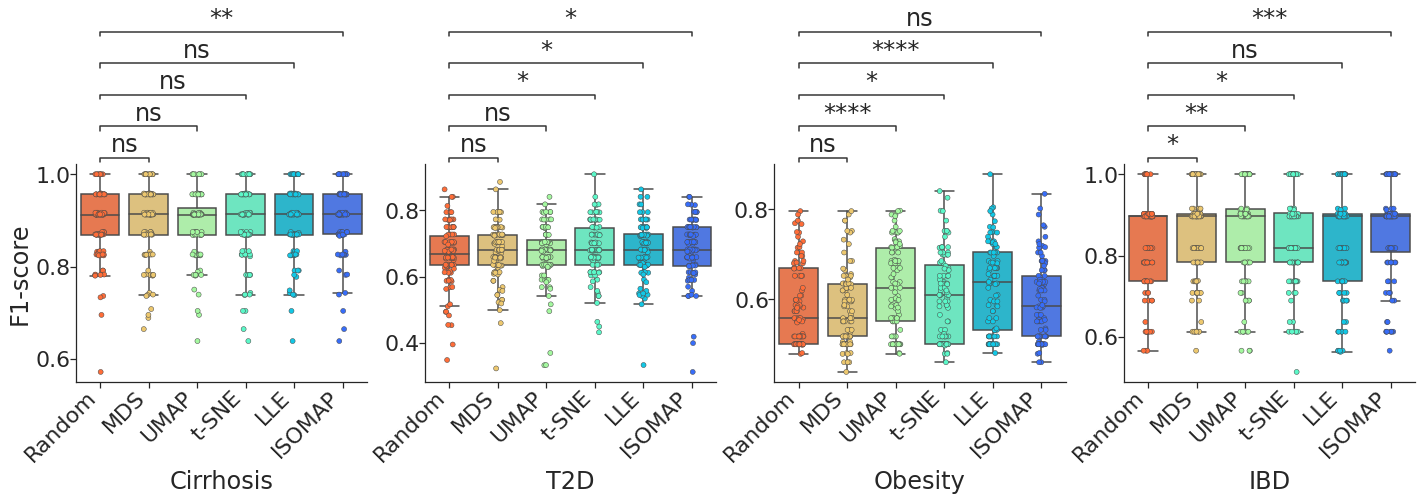

In [9]:
order = ['Random', 'MDS', 'UMAP',  't-SNE', 'LLE', 'ISOMAP'] 
color = sns.color_palette("rainbow_r", len(order)).as_hex() #PiYG

fig, axes = plt.subplots(1, 4, figsize = (24, 4), sharex=True)

for metric in ['f1']: #, 'mcc', 'f1'
    for data,ax,ylim in zip(names, axes, ylims):
        x = "method"
        y = metric
        #data = 'Cirrhosis'
        dfp = dfres[dfres.dataset == data]
        ax = plot_sig(dfp, x, y, order, ax, ylim=None)
        plt.xticks(rotation=45, ha = 'right')
axes[0].set_ylabel('F1-score')

fig.savefig("./results/03_f1_stat.pdf" ,  bbox_inches='tight')
